<a href="https://colab.research.google.com/github/Sandhya-G/Aggression-Detection/blob/master/notebook/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd

# **Summary**

CNN treats embedding matrix as an image, but in text case the convolution matrix must have same number of columns as that of embedding matrix and rows are usually 3,4 or 5 (can be thought of as bigrams, trigrams etc) even though its translation invariant it cannot take care of the context.
![cnn](https://miro.medium.com/max/500/0*0efgxnFIaLTZ2qkY?)

RNN remembers previous information using hidden state.
but it has two problems
Vanishing gradient (exploding gradient can be avoided  using Gradient clipping)
long term dependencies.
Hence variation of RNN
LSTM , bi-LSTM(both sides).
![LSTM unit](https://i.stack.imgur.com/aTDpS.png)
![deep lstm](https://assets.website-files.com/5ac6b7f2924c656f2b13a88c/5b883bbde817297a9cc204a9_Screen%20Shot%202018-08-29%20at%2011.05.17%20AM.png)
The architecture is same for GRU. LSTM is replaced by GRU.
![GRU unit](https://i.stack.imgur.com/PYGtu.png)

GRU(Simplified version of LSTM)


In [5]:
train_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TRAIN%23")
test_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TEST%23")

In [6]:
train_df.head()

,Unnamed: 0,tweet,class
0,0,<user> <hashtag> mendix <hashtag> mendixworld ...,0
1,1,the bitches behind me are so annoying why do n...,1
2,2,<user> you see the bitch with the fake leg tha...,1
3,3,love is love <hashtag> prayfororlando <hashtag...,0
4,4,np of <hashtag> princegeorge attends <hashtag>...,0


In [0]:
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 120 # max number of words in a question to use

In [0]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D,concatenate,add
from keras.layers import Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.constraints import maxnorm

In [0]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

import tensorflow as tf


def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)


    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)




In [0]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

## split to train and val

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2048,stratify=train_df["class"])

## some config values 
embed_size = 100 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 120 # max number of words in a question to use

## fill up the missing values
train_X = train_df["tweet"].fillna("_na_").values
val_X = val_df["tweet"].fillna("_na_").values
test_X = test_df["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen,padding='post',truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen,padding='post',truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen,padding='post',truncating='post')

## Get the target values
train_y = train_df['class'].values
val_y = val_df['class'].values
test_y = test_df['class'].values


        



In [0]:
def load_glove_index():
    EMBEDDING_FILE =  '/content/glove.twitter.27B.100d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:100]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    return embeddings_index

glove_embedding_index = load_glove_index()

In [0]:

num_words = max_features

embedding_matrix = np.zeros((num_words, embed_size))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = glove_embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(30000, 100)

In [0]:
from tensorflow.python.compiler import tensorrt as trt

In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Dropout(0.1)(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
#x = Dropout(0.5)(x)
hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
#hidden = Dropout(0.5)(hidden)
hidden = add([hidden, Dense(4*64, activation='relu',kernel_constraint=maxnorm(4))(hidden)])
hidden = Dropout(0.2)(hidden)
result = Dense(1, activation='sigmoid')(hidden)

model = Model(inputs=inp, outputs=result)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
#model.compile(loss=f1_loss, optimizer='adam', metrics=['accuracy',f1])
print(model.summary())



Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 120)          0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 120, 100)     3000000     input_19[0][0]                   
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 120, 100)     0           embedding_19[0][0]               
__________________________________________________________________________________________________
bidirectional_26 (Bidirectional (None, 120, 128)     63360       dropout_22[0][0]                 
___________________________________________________________________________________________

In [0]:
history = model.fit(train_X, train_y, batch_size=512, epochs=12, validation_data=(val_X, val_y))

Train on 38258 samples, validate on 4251 samples
Epoch 1/12
38258/38258 [==============================] - 54s 1ms/step - loss: 0.3222 - accuracy: 0.8681 - f1: 0.8245 - val_loss: 0.2151 - val_accuracy: 0.9155 - val_f1: 0.8928
Epoch 2/12
38258/38258 [==============================] - 53s 1ms/step - loss: 0.2293 - accuracy: 0.9100 - f1: 0.8870 - val_loss: 0.1989 - val_accuracy: 0.9205 - val_f1: 0.8982
Epoch 3/12
38258/38258 [==============================] - 53s 1ms/step - loss: 0.2115 - accuracy: 0.9159 - f1: 0.8945 - val_loss: 0.1888 - val_accuracy: 0.9207 - val_f1: 0.9010
Epoch 4/12
38258/38258 [==============================] - 52s 1ms/step - loss: 0.2006 - accuracy: 0.9204 - f1: 0.9007 - val_loss: 0.1803 - val_accuracy: 0.9259 - val_f1: 0.9065
Epoch 5/12
38258/38258 [==============================] - 52s 1ms/step - loss: 0.1883 - accuracy: 0.9252 - f1: 0.9065 - val_loss: 0.1806 - val_accuracy: 0.9247 - val_f1: 0.9030
Epoch 6/12
38258/38258 [==============================] - 52s 1ms/

In [0]:
#codes from machinelearningmastery.com
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# codes from machinelearningmastery.com
def print_hist(history):
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('model af1')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

   
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

dict_keys(['val_loss', 'val_accuracy', 'val_f1', 'loss', 'accuracy', 'f1'])


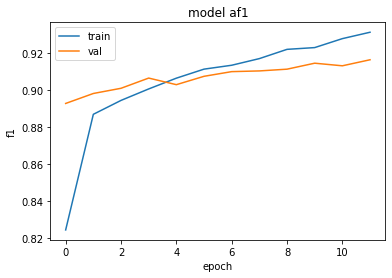

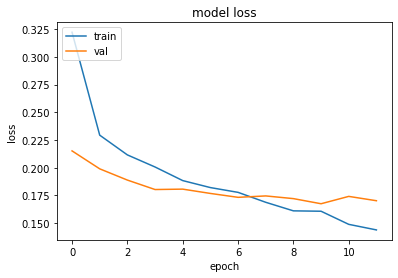

In [0]:
print_hist(history)

In [0]:
inp = Input(shape=(maxlen,))
#x = Dropout(0.1)(x)
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(16, activation="relu")(x)
#x = Dropout(0.2)(x)
x = Dense(1, activation="sigmoid")(x)
model1 = Model(inputs=inp, outputs=x)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
print(model1.summary())





Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 120)               0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 120, 100)          3000000   
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 120, 128)          63360     
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 120, 128)          74112     
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 17 

In [0]:
 history1 = model1.fit(train_X, train_y, batch_size=512, epochs=8, validation_data=(val_X, val_y))

Train on 38258 samples, validate on 4251 samples
Epoch 1/8
38258/38258 [==============================] - 105s 3ms/step - loss: 0.3290 - accuracy: 0.8692 - f1: 0.8245 - val_loss: 0.2245 - val_accuracy: 0.9188 - val_f1: 0.8924
Epoch 2/8
38258/38258 [==============================] - 104s 3ms/step - loss: 0.2220 - accuracy: 0.9140 - f1: 0.8912 - val_loss: 0.1982 - val_accuracy: 0.9195 - val_f1: 0.8988
Epoch 3/8
38258/38258 [==============================] - 104s 3ms/step - loss: 0.2041 - accuracy: 0.9182 - f1: 0.8972 - val_loss: 0.1848 - val_accuracy: 0.9221 - val_f1: 0.9020
Epoch 4/8
38258/38258 [==============================] - 104s 3ms/step - loss: 0.1915 - accuracy: 0.9230 - f1: 0.9033 - val_loss: 0.1792 - val_accuracy: 0.9259 - val_f1: 0.9080
Epoch 5/8
38258/38258 [==============================] - 103s 3ms/step - loss: 0.1824 - accuracy: 0.9280 - f1: 0.9103 - val_loss: 0.1739 - val_accuracy: 0.9294 - val_f1: 0.9115
Epoch 6/8
38258/38258 [==============================] - 105s 3ms/

In [0]:

#print_hist(history1)

In [0]:
pred_glove_test_y = model.predict([test_X], batch_size=1024, verbose=1)
# scores = []
# thresholds = np.arange(0.1, 0.501, 0.01)
# for thresh in thresholds:
#     thresh = np.round(thresh, 2)
#     scores.append(metrics.f1_score(train_y, (pred_glove_train_y>thresh).astype(int)))
#     print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(train_y, (pred_glove_train_y>thresh).astype(int))))
# idx = np.argmax(np.array(scores))
# thresh_train = thresholds[idx]

11949/11949 [==============================] - 1s 62us/step


In [0]:
pred_glove_train_y = model.predict([train_X], batch_size=1024, verbose=1)
scores = []
thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
    thresh = np.round(thresh, 2)
    scores.append(metrics.f1_score(train_y, (pred_glove_train_y>thresh).astype(int)))
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(train_y, (pred_glove_train_y>thresh).astype(int))))
idx = np.argmax(np.array(scores))
thresh_train = thresholds[idx]

38258/38258 [==============================] - 2s 52us/step
F1 score at threshold 0.1 is 0.8620633454663985
F1 score at threshold 0.11 is 0.8680732287989491
F1 score at threshold 0.12 is 0.8738838055341196
F1 score at threshold 0.13 is 0.8786870703038367
F1 score at threshold 0.14 is 0.8832269394809467
F1 score at threshold 0.15 is 0.8878918737031014
F1 score at threshold 0.16 is 0.8919193057590443
F1 score at threshold 0.17 is 0.8958917296639203
F1 score at threshold 0.18 is 0.8991185669604776
F1 score at threshold 0.19 is 0.9027044007196504
F1 score at threshold 0.2 is 0.9059936908517351
F1 score at threshold 0.21 is 0.9090751944684529
F1 score at threshold 0.22 is 0.9121619667389733
F1 score at threshold 0.23 is 0.9148015907573515
F1 score at threshold 0.24 is 0.9179200186545412
F1 score at threshold 0.25 is 0.9205559619604975
F1 score at threshold 0.26 is 0.9226253375601737
F1 score at threshold 0.27 is 0.9244994110718492
F1 score at threshold 0.28 is 0.9268595407665711
F1 score at

In [0]:
print(thresh_train)


0.4999999999999998


In [0]:
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
scores = []
thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
    thresh = np.round(thresh, 2)
    scores.append(metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int)))
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))
idx = np.argmax(np.array(scores))
thresh_valid = thresholds[idx]

4251/4251 [==============================] - 0s 62us/step
F1 score at threshold 0.1 is 0.8465686274509805
F1 score at threshold 0.11 is 0.8505803902198074
F1 score at threshold 0.12 is 0.8553677932405567
F1 score at threshold 0.13 is 0.8602904356534804
F1 score at threshold 0.14 is 0.8628930817610063
F1 score at threshold 0.15 is 0.8678481012658228
F1 score at threshold 0.16 is 0.8714031066972244
F1 score at threshold 0.17 is 0.8719652440582673
F1 score at threshold 0.18 is 0.8753206772703951
F1 score at threshold 0.19 is 0.8780613560195927
F1 score at threshold 0.2 is 0.8792345487457979
F1 score at threshold 0.21 is 0.8823682160477797
F1 score at threshold 0.22 is 0.8836240562353554
F1 score at threshold 0.23 is 0.88662486938349
F1 score at threshold 0.24 is 0.8891218872870249
F1 score at threshold 0.25 is 0.8909329829172142
F1 score at threshold 0.26 is 0.8919915700737617
F1 score at threshold 0.27 is 0.8931216931216931
F1 score at threshold 0.28 is 0.8949044585987261
F1 score at thr

In [0]:
print(thresh_valid)

0.47999999999999976


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

print('total valid data is ',test_y.shape[0], 'where', np.sum(test_y==1),'is hate' )
print(f1_score(test_y, pred_glove_test_y>0.41))
#confusion_matrix(train_y, pred_glove_train_y>thresh_train, labels=[0, 1])

total valid data is  11949 where 4981 is hate
0.9364288561179753


In [0]:
print('total valid data is ',val_y.shape[0], 'where', np.sum(val_y==1),'is hate' )
print(accuracy_score(val_y, pred_glove_val_y>thresh_valid))
confusion_matrix(val_y, pred_glove_val_y>thresh_valid, labels=[0, 1])



total valid data is  4251 where 1769 is hate
0.9520112914608327


array([[2384,   98],
       [ 106, 1663]])

In [0]:
#predicted = model1.predict(test_X) > 0.5

In [0]:
#metrics.f1_score(predicted,test_y)

In [0]:
def predict_result(text):
  val = tokenizer.texts_to_sequences([text])
  val = pad_sequences(val, maxlen=maxlen,padding='post',truncating='post')
  return model.predict(val)[0]


In [0]:
predict_result("That is fucking great") 

array([0.37764966], dtype=float32)

In [0]:
predict_result("you are so fucking annoying shut up ") 

array([0.6022347], dtype=float32)

In [0]:
predict_result("look at those damn prices") 

array([0.29732585], dtype=float32)

In [0]:
predict_result("what the fuck") 

array([0.48650774], dtype=float32)

In [0]:
predict_result("go kill yourself")

array([0.5289312], dtype=float32)

In [0]:
predict_result("kill yourself")

array([0.7191925], dtype=float32)

In [0]:
predict_result("fuck you") 

array([0.8542695], dtype=float32)

In [0]:
predict_result("can we  ban black people")

array([0.7232004], dtype=float32)

In [0]:
predict_result("<user>  ban black people")

array([0.7278909], dtype=float32)

In [0]:
predict_result("black people are humans too")

array([0.39425012], dtype=float32)

In [0]:
predict_result("<user> ban the drugs")

array([0.13512719], dtype=float32)

In [0]:
# pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
# scores = []
# thresholds = np.arange(0.1, 0.501, 0.01)
# for thresh in thresholds:
#     thresh = np.round(thresh, 2)
#     scores.append(metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int)))
#     print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))
# idx = np.argmax(np.array(scores))
# thresh_valid = thresholds[idx]